In [1]:
import meva
from meva.lib.spin import get_pretrained_hmr
import mmcv 
import torch
from meva.utils import image_utils
from utils import imshow
from skimage.transform import resize
import numpy as np
import data
from utils import makedirs_ifno
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [6]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
anno_folder = '/media/tormod/Den Lille/Thesis/annotations'
out_folder = '/media/tormod/Den Lille/Thesis/hmr_features'
c = data.ClimbingDataset(vid_folder, anno_folder, 'all', seq_len=1)#, feat_folder=out_folder)

In [5]:
hmr = get_pretrained_hmr()

====> Loading pre trained: data/meva_data/spin_model_checkpoint.pth.tar


In [6]:
hmr.eval()
d = c.get(0)
imgs = d['norm_imgs']
imgs = imgs[:1]
imgs = imgs.float().to('cuda')
feat, out = hmr(imgs, return_features=True)

In [7]:
out[0].keys()

dict_keys(['theta', 'verts', 'kp_2d', 'kp_3d'])

In [8]:
d.keys()

dict_keys(['raw_imgs', 'norm_imgs', 'features', 'climb_labels', 'kp_2d', 'vid_idx', 'frames', 'bboxes', 'trans', 'inv_trans'])

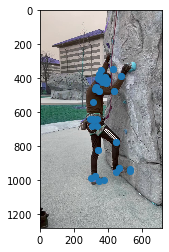

In [16]:
img = d['raw_imgs'][0]
norm_img = d['norm_imgs'][0]
plt.imshow(img)
kp_2d = out[0]['kp_2d'].cpu().detach().numpy()[0]
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
#kp_3d = out[0]['kp_3d'].cpu().detach().numpy()[0]
kp_2d = image_utils.trans_points2d(kp_2d, d['inv_trans'])
plt.scatter(kp_2d[:,0], kp_2d[:,1])

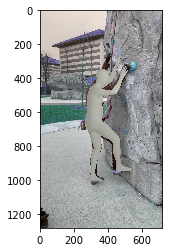

In [34]:
import mesh
verts = out[0]['verts'][0].cpu().detach().numpy()
theta = out[0]['theta'][0].cpu().detach().numpy()
pred_cam = theta[:3]
plt.imshow(mesh.render_pred_mesh(img, d['bboxes'][:1], verts, pred_cam))

In [35]:
makedirs_ifno([f'{out_folder}/{n}/' for n in c.stripped_names])

for seq in tqdm(c):
    imgs = seq['norm_imgs']
    vid_name = c.stripped_names[seq['vid_idx']]
    frames = seq['frames']
    for f, img in zip(frames, imgs):
        img = img.float().unsqueeze(0).to('cuda')
        feat, out = hmr(img, return_features=True)
        feat = feat.cpu().detach().numpy()[0]
        out = out[0]
        out = dict([(k, out[k].cpu().detach().numpy()) for k in out])
        out['features'] = feat
        np.save(f'{out_folder}/{vid_name}/{f:06d}', out)
        

In [ ]:
res = np.load(f'{out_folder}/{c.stripped_names[0]}/000001.npy', allow_pickle=True)

In [ ]:
res.item()['features']